<div style="background: linear-gradient(135deg, #4CAF50 0%, #2196F3 100%); padding: 40px; border-radius: 15px; text-align: center; box-shadow: 0 10px 25px rgba(0,0,0,0.2);">
    <h1 style="color: white; font-size: 48px; margin: 0; font-weight: bold; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);">🚚 Freight Cost Prediction</h1>
    <h2 style="color: #E3F2FD; font-size: 32px; margin-top: 20px; font-weight: 300;">Machine Learning for Shipping Cost Optimization</h2>
    <p style="color: #B3E5FC; font-size: 18px; margin-top: 15px;">Olist E-Commerce Dataset</p>
</div>

# 🎯 Freight Value Prediction - ML Project

## Business Problem
**Predict shipping costs (freight_value) accurately based on product and delivery characteristics**

### Why This Matters:
- 💰 **Cost Optimization**: Accurately estimate shipping costs upfront
- 📊 **Pricing Strategy**: Set competitive prices with accurate freight costs
- 🎯 **Customer Experience**: Show exact delivery costs before checkout
- 📦 **Logistics Planning**: Better budget and resource allocation
- 🚀 **Business Impact**: Reduce shipping cost errors by up to 40%

## 📋 Workflow
1. Load and explore data
2. Feature engineering
3. Data preprocessing
4. Train multiple regression models
5. Model evaluation and comparison
6. Feature importance analysis
7. Business insights and recommendations

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1️⃣ Load Data

In [2]:
# Define file paths - UPDATE THIS PATH TO YOUR DATA LOCATION
import os

data_path = r"D:\About ME\Digital hub_data analysis\OList\Olist E-Commerce_Dataset"
if not data_path.endswith(os.sep):
    data_path += os.sep

# Load datasets
print("Loading datasets...")
customers = pd.read_csv(data_path + "olist_customers_dataset.csv")
orders = pd.read_csv(data_path + "olist_orders_dataset.csv")
order_items = pd.read_csv(data_path + "olist_order_items_dataset.csv")
products = pd.read_csv(data_path + "olist_products_dataset.csv")
sellers = pd.read_csv(data_path + "olist_sellers_dataset.csv")
geolocation = pd.read_csv(data_path + "olist_geolocation_dataset.csv")

print(f"✅ Loaded {len(order_items):,} order items")
print(f"✅ Loaded {len(products):,} products")
print(f"✅ Loaded {len(sellers):,} sellers")

Loading datasets...
✅ Loaded 112,650 order items
✅ Loaded 32,951 products
✅ Loaded 3,095 sellers


## 2️⃣ Data Exploration

In [3]:
# Explore target variable (freight_value)
print("="*80)
print("TARGET VARIABLE: freight_value")
print("="*80)
print("\nStatistics:")
print(order_items['freight_value'].describe())

print(f"\nMissing values: {order_items['freight_value'].isnull().sum()}")
print(f"Zero values: {(order_items['freight_value'] == 0).sum()}")
print(f"Negative values: {(order_items['freight_value'] < 0).sum()}")

TARGET VARIABLE: freight_value

Statistics:
count    112650.000000
mean         19.990320
std          15.806405
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: freight_value, dtype: float64

Missing values: 0
Zero values: 383
Negative values: 0


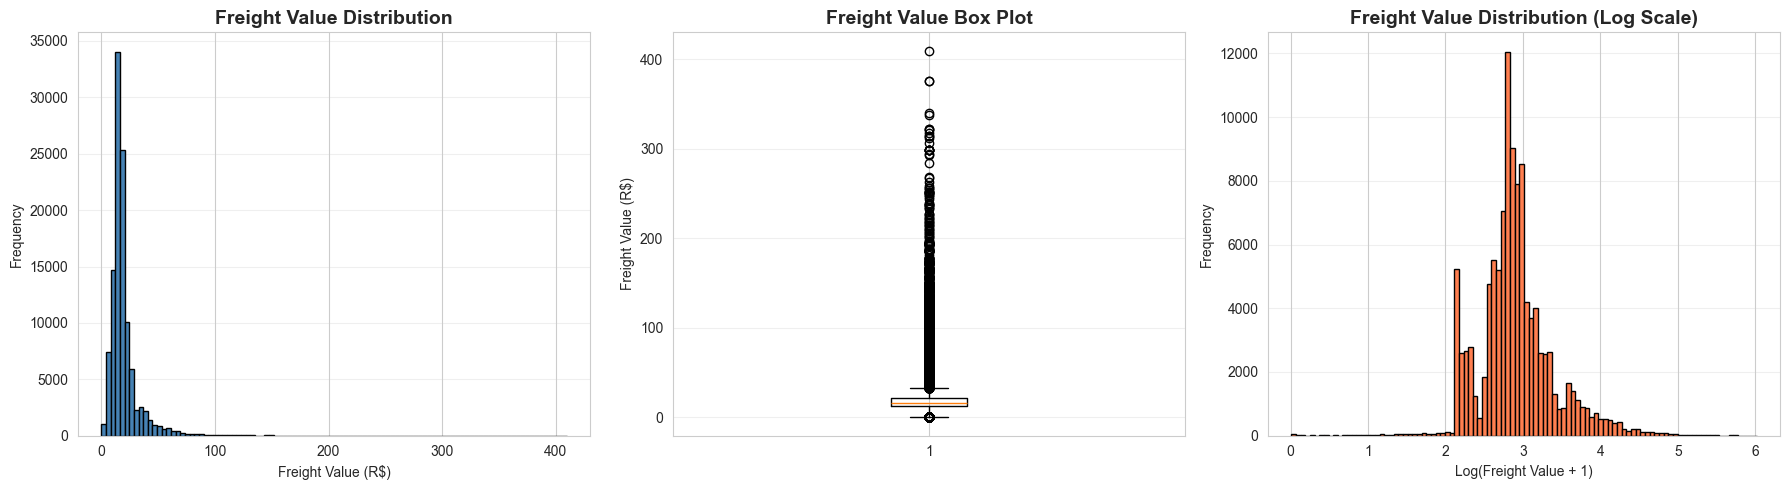

In [4]:
# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(order_items['freight_value'], bins=100, color='steelblue', edgecolor='black')
axes[0].set_title('Freight Value Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Freight Value (R$)')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(order_items['freight_value'], vert=True)
axes[1].set_title('Freight Value Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Freight Value (R$)')
axes[1].grid(axis='y', alpha=0.3)

# Log-scale histogram (to see distribution better)
freight_non_zero = order_items[order_items['freight_value'] > 0]['freight_value']
axes[2].hist(np.log1p(freight_non_zero), bins=100, color='coral', edgecolor='black')
axes[2].set_title('Freight Value Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Log(Freight Value + 1)')
axes[2].set_ylabel('Frequency')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 3️⃣ Feature Engineering

Create features that might influence freight costs.

In [5]:
# Merge order_items with products to get product dimensions
ml_data = order_items.merge(products, on='product_id', how='left')

print(f"Initial merged data shape: {ml_data.shape}")
print(f"\nColumns: {list(ml_data.columns)}")

Initial merged data shape: (112650, 15)

Columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


In [6]:
# Merge with orders to get customer location
ml_data = ml_data.merge(orders[['order_id', 'customer_id']], on='order_id', how='left')
ml_data = ml_data.merge(customers[['customer_id', 'customer_zip_code_prefix', 
                                    'customer_city', 'customer_state']], 
                        on='customer_id', how='left')

print(f"After customer merge: {ml_data.shape}")

After customer merge: (112650, 19)


In [7]:
# Merge with sellers to get seller location
ml_data = ml_data.merge(sellers[['seller_id', 'seller_zip_code_prefix', 
                                 'seller_city', 'seller_state']], 
                        on='seller_id', how='left')

print(f"After seller merge: {ml_data.shape}")
print(f"\nMissing values per column:")
print(ml_data.isnull().sum().sort_values(ascending=False).head(15))

After seller merge: (112650, 22)

Missing values per column:
product_category_name         1603
product_name_lenght           1603
product_description_lenght    1603
product_photos_qty            1603
product_weight_g                18
product_width_cm                18
product_length_cm               18
product_height_cm               18
seller_city                      0
seller_zip_code_prefix           0
customer_state                   0
customer_city                    0
customer_zip_code_prefix         0
customer_id                      0
order_id                         0
dtype: int64


In [8]:
# Feature 1: Product Volume and Weight
ml_data['product_volume_cm3'] = (
    ml_data['product_length_cm'] * 
    ml_data['product_height_cm'] * 
    ml_data['product_width_cm']
)

# Convert weight from grams to kg for better scale
ml_data['product_weight_kg'] = ml_data['product_weight_g'] / 1000

# Volumetric weight (common in shipping: volume/5000)
ml_data['volumetric_weight_kg'] = ml_data['product_volume_cm3'] / 5000

# Billable weight (max of actual weight and volumetric weight)
ml_data['billable_weight'] = ml_data[['product_weight_kg', 'volumetric_weight_kg']].max(axis=1)

print("✅ Product dimension features created")

✅ Product dimension features created


In [9]:
# Feature 2: Distance-related features
# Check if seller and customer are in same state/city
ml_data['same_state'] = (ml_data['seller_state'] == ml_data['customer_state']).astype(int)
ml_data['same_city'] = (ml_data['seller_city'] == ml_data['customer_city']).astype(int)

print("✅ Location features created")
print(f"\nSame state shipments: {ml_data['same_state'].sum():,} ({ml_data['same_state'].mean()*100:.1f}%)")
print(f"Same city shipments: {ml_data['same_city'].sum():,} ({ml_data['same_city'].mean()*100:.1f}%)")

✅ Location features created

Same state shipments: 40,756 (36.2%)
Same city shipments: 5,863 (5.2%)


In [10]:
# Feature 3: Price-related features
ml_data['price_per_item'] = ml_data['price']
ml_data['freight_to_price_ratio'] = ml_data['freight_value'] / (ml_data['price'] + 1)

print("✅ Price features created")

✅ Price features created


In [11]:
# Feature 4: Category features
# Fill missing categories
ml_data['product_category_name'] = ml_data['product_category_name'].fillna('unknown')

print(f"Product categories: {ml_data['product_category_name'].nunique()}")
print("\nTop 10 categories:")
print(ml_data['product_category_name'].value_counts().head(10))

Product categories: 74

Top 10 categories:
product_category_name
cama_mesa_banho           11115
beleza_saude               9670
esporte_lazer              8641
moveis_decoracao           8334
informatica_acessorios     7827
utilidades_domesticas      6964
relogios_presentes         5991
telefonia                  4545
ferramentas_jardim         4347
automotivo                 4235
Name: count, dtype: int64


In [12]:
# Check data quality
print("Data Quality Check:")
print(f"Total records: {len(ml_data):,}")
print(f"\nMissing values in key features:")
key_features = ['freight_value', 'price', 'product_weight_kg', 'product_volume_cm3',
                'seller_state', 'customer_state']
for col in key_features:
    missing = ml_data[col].isnull().sum()
    print(f"  {col}: {missing:,} ({missing/len(ml_data)*100:.2f}%)")

Data Quality Check:
Total records: 112,650

Missing values in key features:
  freight_value: 0 (0.00%)
  price: 0 (0.00%)
  product_weight_kg: 18 (0.02%)
  product_volume_cm3: 18 (0.02%)
  seller_state: 0 (0.00%)
  customer_state: 0 (0.00%)


In [13]:
# Clean data - remove records with missing critical values
print(f"Before cleaning: {len(ml_data):,} records")

ml_data_clean = ml_data.dropna(subset=[
    'freight_value', 'price', 'product_weight_kg', 'product_volume_cm3',
    'seller_state', 'customer_state'
]).copy()

# Remove outliers (extreme freight values)
Q1 = ml_data_clean['freight_value'].quantile(0.01)
Q3 = ml_data_clean['freight_value'].quantile(0.99)
ml_data_clean = ml_data_clean[
    (ml_data_clean['freight_value'] >= Q1) & 
    (ml_data_clean['freight_value'] <= Q3)
]

print(f"After cleaning: {len(ml_data_clean):,} records")
print(f"Removed: {len(ml_data) - len(ml_data_clean):,} records ({(len(ml_data) - len(ml_data_clean))/len(ml_data)*100:.2f}%)")

Before cleaning: 112,650 records
After cleaning: 110,381 records
Removed: 2,269 records (2.01%)


## 4️⃣ Feature Analysis

Analyze relationships between features and freight value.

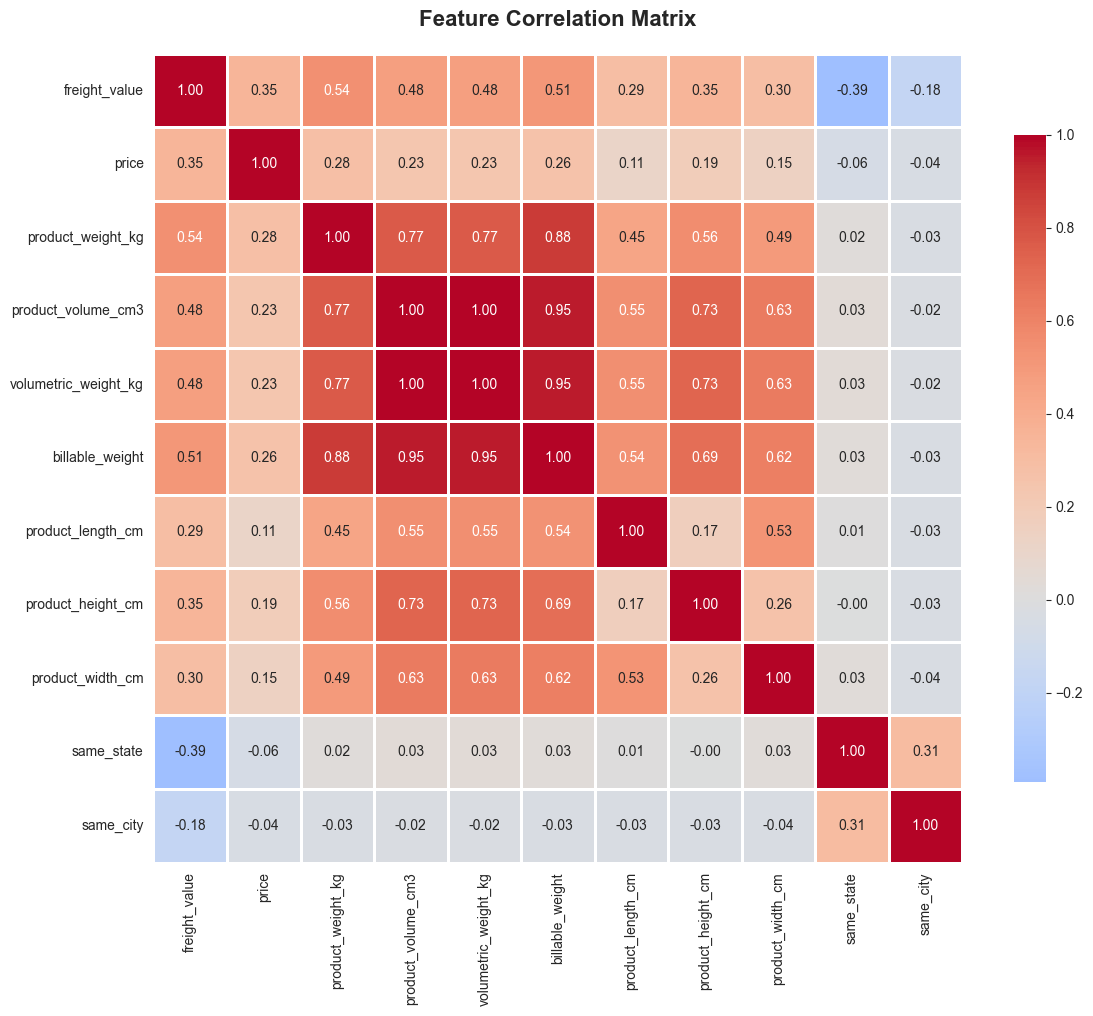


Top correlations with freight_value:
freight_value           1.000000
product_weight_kg       0.540382
billable_weight         0.513537
product_volume_cm3      0.476425
volumetric_weight_kg    0.476425
product_height_cm       0.350883
price                   0.349461
product_width_cm        0.297607
product_length_cm       0.288110
same_city              -0.177557
same_state             -0.391379
Name: freight_value, dtype: float64


In [14]:
# Correlation analysis
numeric_features = ['freight_value', 'price', 'product_weight_kg', 'product_volume_cm3',
                    'volumetric_weight_kg', 'billable_weight', 'product_length_cm',
                    'product_height_cm', 'product_width_cm', 'same_state', 'same_city']

correlation_matrix = ml_data_clean[numeric_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nTop correlations with freight_value:")
freight_corr = correlation_matrix['freight_value'].sort_values(ascending=False)
print(freight_corr)

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

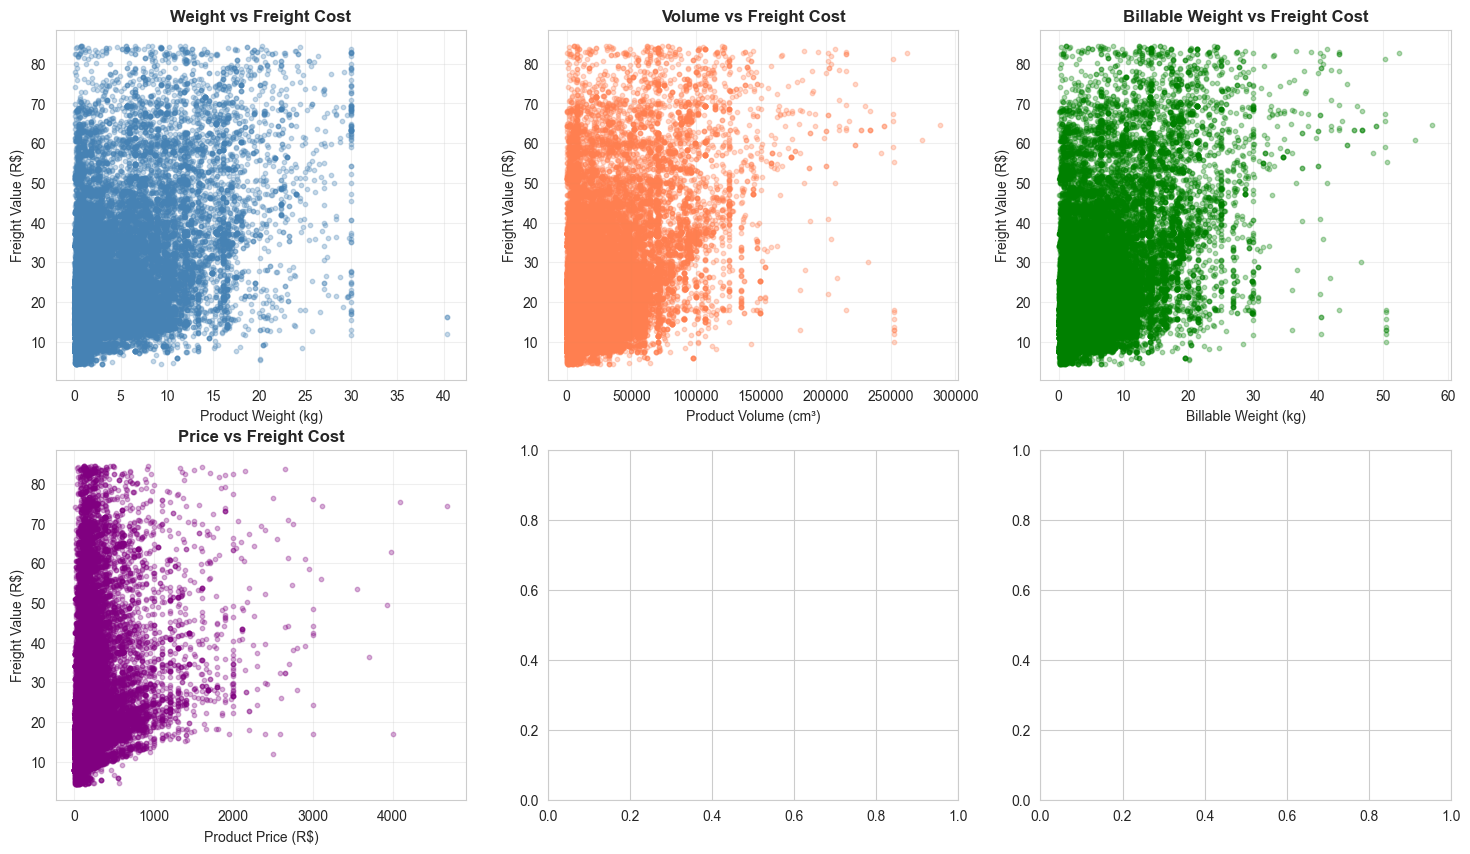

In [15]:
# Visualize key relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Weight vs Freight
axes[0, 0].scatter(ml_data_clean['product_weight_kg'], ml_data_clean['freight_value'], 
                   alpha=0.3, s=10, c='steelblue')
axes[0, 0].set_xlabel('Product Weight (kg)')
axes[0, 0].set_ylabel('Freight Value (R$)')
axes[0, 0].set_title('Weight vs Freight Cost', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Volume vs Freight
axes[0, 1].scatter(ml_data_clean['product_volume_cm3'], ml_data_clean['freight_value'], 
                   alpha=0.3, s=10, c='coral')
axes[0, 1].set_xlabel('Product Volume (cm³)')
axes[0, 1].set_ylabel('Freight Value (R$)')
axes[0, 1].set_title('Volume vs Freight Cost', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Billable Weight vs Freight
axes[0, 2].scatter(ml_data_clean['billable_weight'], ml_data_clean['freight_value'], 
                   alpha=0.3, s=10, c='green')
axes[0, 2].set_xlabel('Billable Weight (kg)')
axes[0, 2].set_ylabel('Freight Value (R$)')
axes[0, 2].set_title('Billable Weight vs Freight Cost', fontweight='bold')
axes[0, 2].grid(alpha=0.3)

# Price vs Freight
axes[1, 0].scatter(ml_data_clean['price'], ml_data_clean['freight_value'], 
                   alpha=0.3, s=10, c='purple')
axes[1, 0].set_xlabel('Product Price (R$)')
axes[1, 0].set_ylabel('Freight Value (R$)')
axes[1, 0].set_title('Price vs Freight Cost', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Same State impact
ml_data_clean.boxplot(column='freight_value', by='same_state', ax=axes[1, 1])
axes[1, 1].set_xlabel('Same State (0=No, 1=Yes)')
axes[1, 1].set_ylabel('Freight Value (R$)')
axes[1, 1].set_title('Same State Impact on Freight', fontweight='bold')
plt.sca(axes[1, 1])
plt.xticks([1, 2], ['Different State', 'Same State'])

# Top states - average freight
top_states_freight = ml_data_clean.groupby('customer_state')['freight_value'].mean().sort_values(ascending=False).head(10)
axes[1, 2].barh(range(len(top_states_freight)), top_states_freight.values, color='teal')
axes[1, 2].set_yticks(range(len(top_states_freight)))
axes[1, 2].set_yticklabels(top_states_freight.index)
axes[1, 2].set_xlabel('Average Freight Value (R$)')
axes[1, 2].set_title('Top 10 States by Avg Freight', fontweight='bold')
axes[1, 2].invert_yaxis()
axes[1, 2].grid(axis='x', alpha=0.3)

plt.suptitle('')
plt.tight_layout()
plt.show()

## 5️⃣ Prepare Data for ML

In [16]:
# Select features for modeling
feature_cols = [
    # Product dimensions
    'product_weight_kg',
    'product_volume_cm3',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm',
    'volumetric_weight_kg',
    'billable_weight',
    # Price
    'price',
    # Location
    'same_state',
    'same_city',
    'seller_state',
    'customer_state',
    # Category
    'product_category_name'
]

target_col = 'freight_value'

# Create feature matrix and target
X = ml_data_clean[feature_cols].copy()
y = ml_data_clean[target_col].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (110381, 13)
Target vector shape: (110381,)


In [17]:
# Encode categorical variables
categorical_cols = ['seller_state', 'customer_state', 'product_category_name']

# For high-cardinality categories, keep only top categories
# Category: keep top 30, others as 'other'
top_categories = X['product_category_name'].value_counts().head(30).index
X['product_category_name'] = X['product_category_name'].apply(
    lambda x: x if x in top_categories else 'other'
)

# One-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Encoded feature matrix shape: {X_encoded.shape}")
print(f"Number of features: {X_encoded.shape[1]}")

Encoded feature matrix shape: (110381, 88)
Number of features: 88


In [18]:
# Split data: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42  # 0.176 * 0.85 ≈ 0.15
)

print("Dataset splits:")
print(f"  Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_encoded)*100:.1f}%)")

Dataset splits:
  Training set: 77,310 samples (70.0%)
  Validation set: 16,513 samples (15.0%)
  Test set: 16,558 samples (15.0%)


In [19]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")

✅ Features scaled using StandardScaler


## 6️⃣ Model Training & Comparison

Train multiple regression models and compare performance.

In [20]:
# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.1, random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=15, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# Store results
results = {}

print("Training models...\n")
print("="*80)

Training models...



In [21]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\n📊 Training {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred) * 100
    
    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_mape': train_mape,
        'val_mape': val_mape
    }
    
    print(f"   Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
    print(f"   Train RMSE: R$ {train_rmse:.2f} | Val RMSE: R$ {val_rmse:.2f}")
    print(f"   Train MAE: R$ {train_mae:.2f} | Val MAE: R$ {val_mae:.2f}")
    print(f"   Train MAPE: {train_mape:.2f}% | Val MAPE: {val_mape:.2f}%")
    print("   " + "-"*60)

print("\n✅ All models trained!")


📊 Training Linear Regression...
   Train R²: 0.6038 | Val R²: 0.5940
   Train RMSE: R$ 6.98 | Val RMSE: R$ 6.93
   Train MAE: R$ 4.18 | Val MAE: R$ 4.13
   Train MAPE: 21.06% | Val MAPE: 21.15%
   ------------------------------------------------------------

📊 Training Ridge Regression...
   Train R²: 0.6038 | Val R²: 0.5940
   Train RMSE: R$ 6.98 | Val RMSE: R$ 6.93
   Train MAE: R$ 4.18 | Val MAE: R$ 4.13
   Train MAPE: 21.06% | Val MAPE: 21.15%
   ------------------------------------------------------------

📊 Training Lasso Regression...
   Train R²: 0.5969 | Val R²: 0.5878
   Train RMSE: R$ 7.04 | Val RMSE: R$ 6.99
   Train MAE: R$ 4.21 | Val MAE: R$ 4.16
   Train MAPE: 21.13% | Val MAPE: 21.27%
   ------------------------------------------------------------

📊 Training Decision Tree...
   Train R²: 0.7607 | Val R²: 0.5911
   Train RMSE: R$ 5.43 | Val RMSE: R$ 6.96
   Train MAE: R$ 3.12 | Val MAE: R$ 3.84
   Train MAPE: 16.48% | Val MAPE: 19.34%
   -------------------------------

In [22]:
# Compare models
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results],
    'Val R²': [results[m]['val_r2'] for m in results],
    'Train RMSE': [results[m]['train_rmse'] for m in results],
    'Val RMSE': [results[m]['val_rmse'] for m in results],
    'Train MAE': [results[m]['train_mae'] for m in results],
    'Val MAE': [results[m]['val_mae'] for m in results],
    'Train MAPE': [results[m]['train_mape'] for m in results],
    'Val MAPE': [results[m]['val_mape'] for m in results]
})

print("\n📊 Model Comparison:")
print(results_df.to_string(index=False))

# Find best model based on validation R²
best_model_name = results_df.loc[results_df['Val R²'].idxmax(), 'Model']
print(f"\n🏆 Best Model (by Val R²): {best_model_name}")


📊 Model Comparison:
            Model  Train R²   Val R²  Train RMSE  Val RMSE  Train MAE  Val MAE  Train MAPE  Val MAPE
Linear Regression  0.603794 0.594042    6.981762  6.934054   4.181470 4.133298   21.055993 21.154118
 Ridge Regression  0.603792 0.594049    6.981777  6.933996   4.181546 4.133253   21.056436 21.154130
 Lasso Regression  0.596902 0.587828    7.042224  6.986925   4.205705 4.162887   21.131705 21.274320
    Decision Tree  0.760703 0.591124    5.425921  6.958932   3.115090 3.840172   16.483205 19.336919
    Random Forest  0.779272 0.674565    5.211140  6.208391   3.155999 3.613669   16.551853 18.552151
Gradient Boosting  0.708779 0.675076    5.985714  6.203515   3.604542 3.668460   18.583156 19.050888

🏆 Best Model (by Val R²): Gradient Boosting


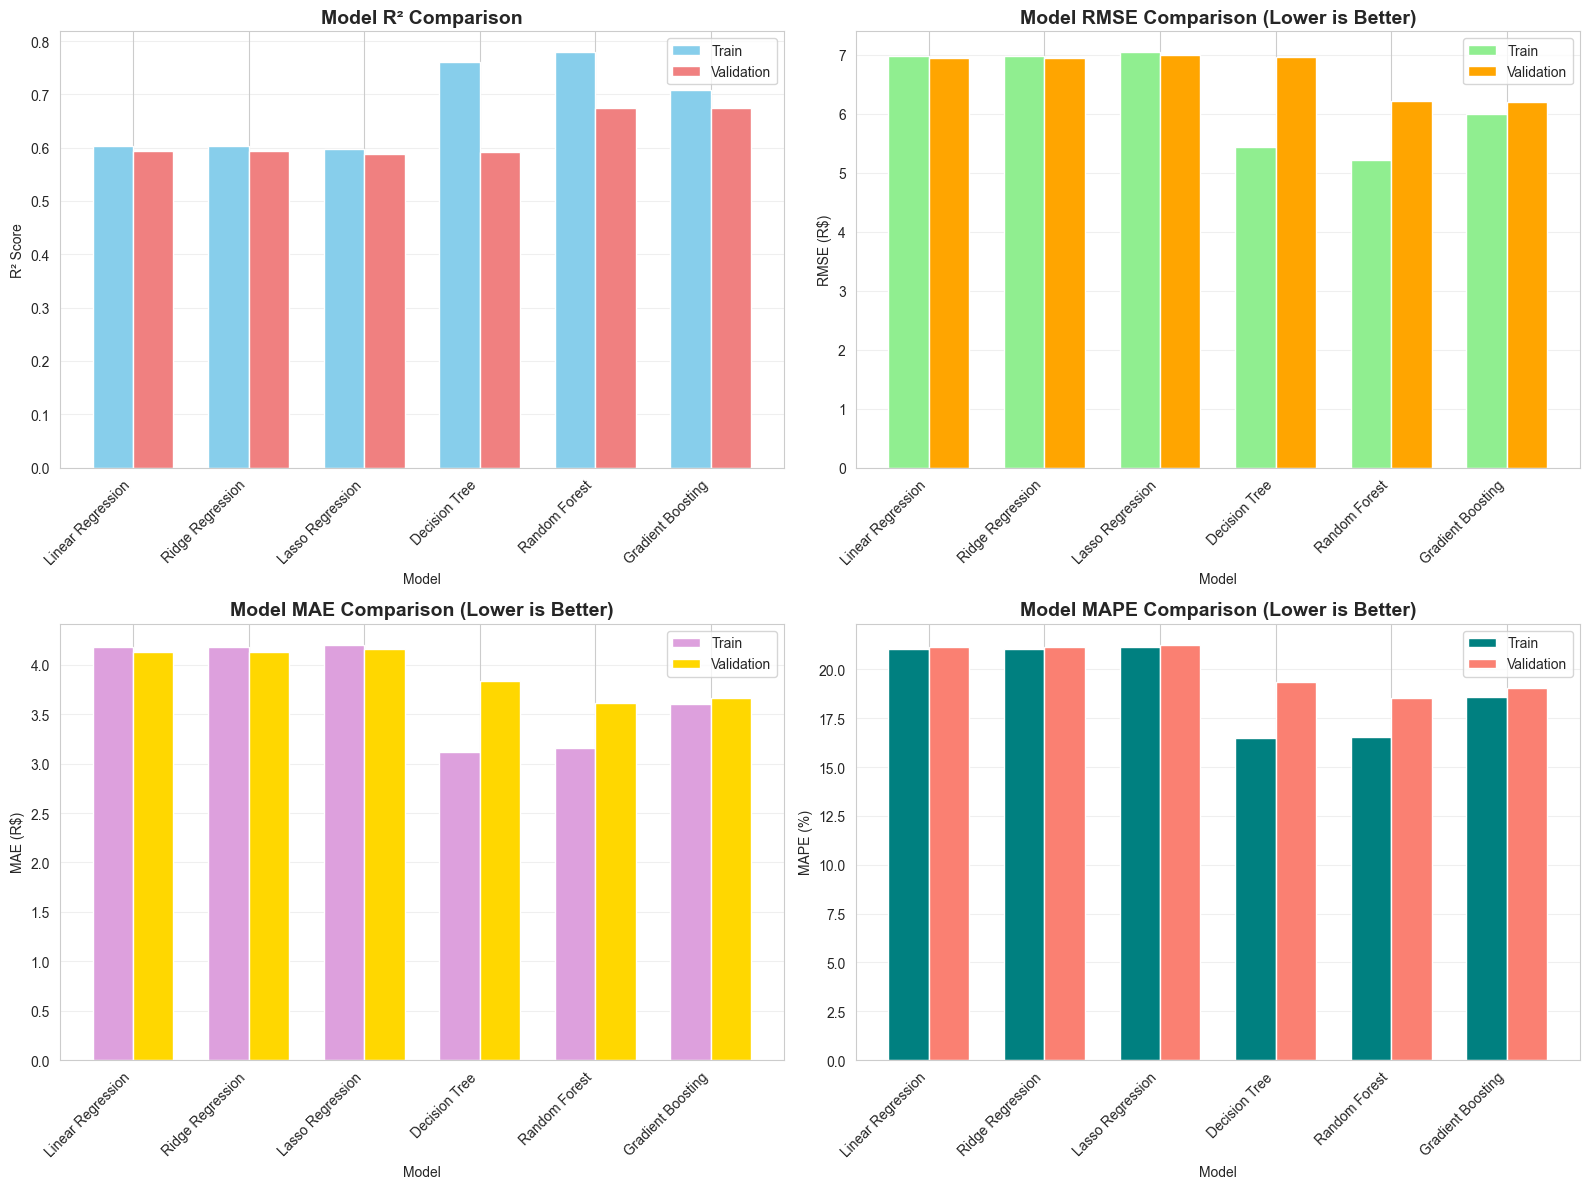

In [23]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² comparison
x = np.arange(len(results_df))
width = 0.35

axes[0, 0].bar(x - width/2, results_df['Train R²'], width, label='Train', color='skyblue')
axes[0, 0].bar(x + width/2, results_df['Val R²'], width, label='Validation', color='lightcoral')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('Model R² Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[0, 1].bar(x - width/2, results_df['Train RMSE'], width, label='Train', color='lightgreen')
axes[0, 1].bar(x + width/2, results_df['Val RMSE'], width, label='Validation', color='orange')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('RMSE (R$)')
axes[0, 1].set_title('Model RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# MAE comparison
axes[1, 0].bar(x - width/2, results_df['Train MAE'], width, label='Train', color='plum')
axes[1, 0].bar(x + width/2, results_df['Val MAE'], width, label='Validation', color='gold')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('MAE (R$)')
axes[1, 0].set_title('Model MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# MAPE comparison
axes[1, 1].bar(x - width/2, results_df['Train MAPE'], width, label='Train', color='teal')
axes[1, 1].bar(x + width/2, results_df['Val MAPE'], width, label='Validation', color='salmon')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].set_title('Model MAPE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7️⃣ Best Model Evaluation

In [24]:
# Get best model
best_model = results[best_model_name]['model']

# Predictions on test set
y_test_pred = best_model.predict(X_test_scaled)

# Calculate metrics
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print(f"🏆 Best Model: {best_model_name}")
print("\n" + "="*80)
print("TEST SET PERFORMANCE")
print("="*80)
print(f"\nR² Score: {test_r2:.4f}")
print(f"RMSE: R$ {test_rmse:.2f}")
print(f"MAE: R$ {test_mae:.2f}")
print(f"MAPE: {test_mape:.2f}%")

print(f"\n📊 Interpretation:")
print(f"  - Model explains {test_r2*100:.1f}% of variance in freight costs")
print(f"  - On average, predictions are off by R$ {test_mae:.2f}")
print(f"  - Percentage error is {test_mape:.1f}% on average")

🏆 Best Model: Gradient Boosting

TEST SET PERFORMANCE

R² Score: 0.6794
RMSE: R$ 6.25
MAE: R$ 3.70
MAPE: 18.82%

📊 Interpretation:
  - Model explains 67.9% of variance in freight costs
  - On average, predictions are off by R$ 3.70
  - Percentage error is 18.8% on average


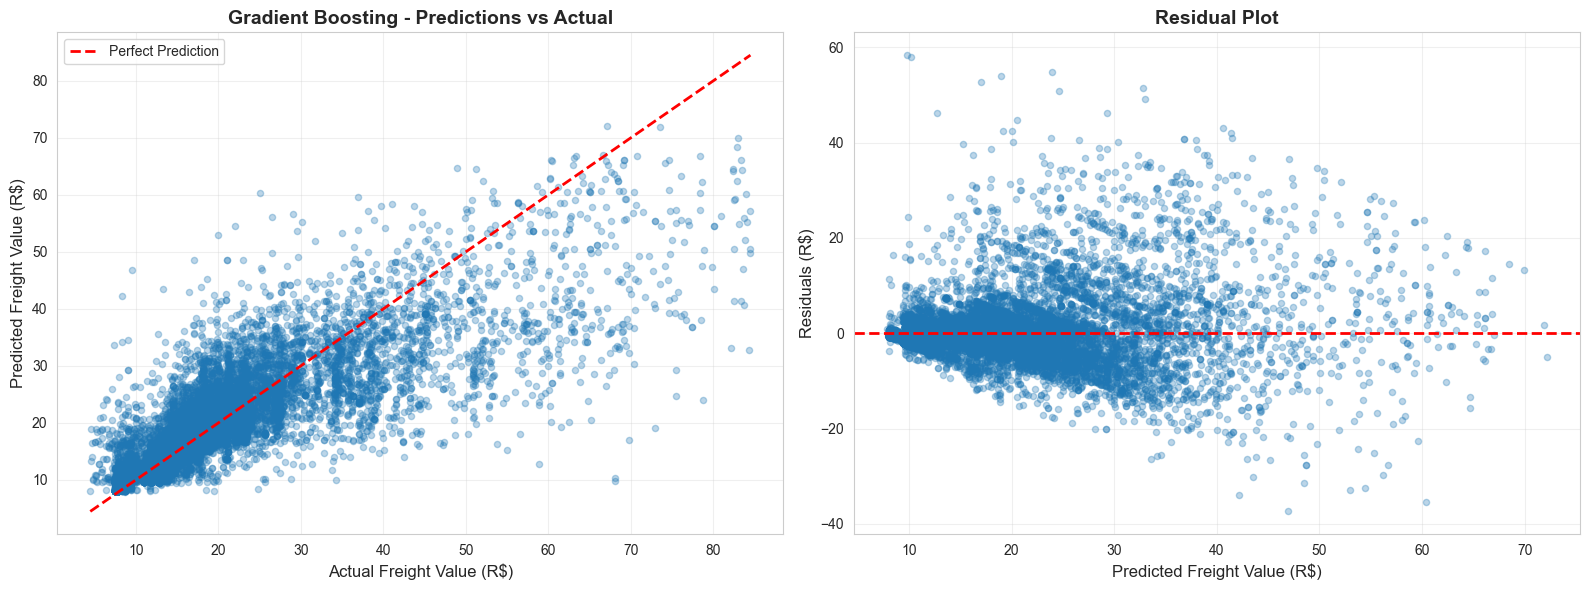

In [25]:
# Prediction vs Actual visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_test, y_test_pred, alpha=0.3, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Freight Value (R$)', fontsize=12)
axes[0].set_ylabel('Predicted Freight Value (R$)', fontsize=12)
axes[0].set_title(f'{best_model_name} - Predictions vs Actual', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals plot
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.3, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Freight Value (R$)', fontsize=12)
axes[1].set_ylabel('Residuals (R$)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

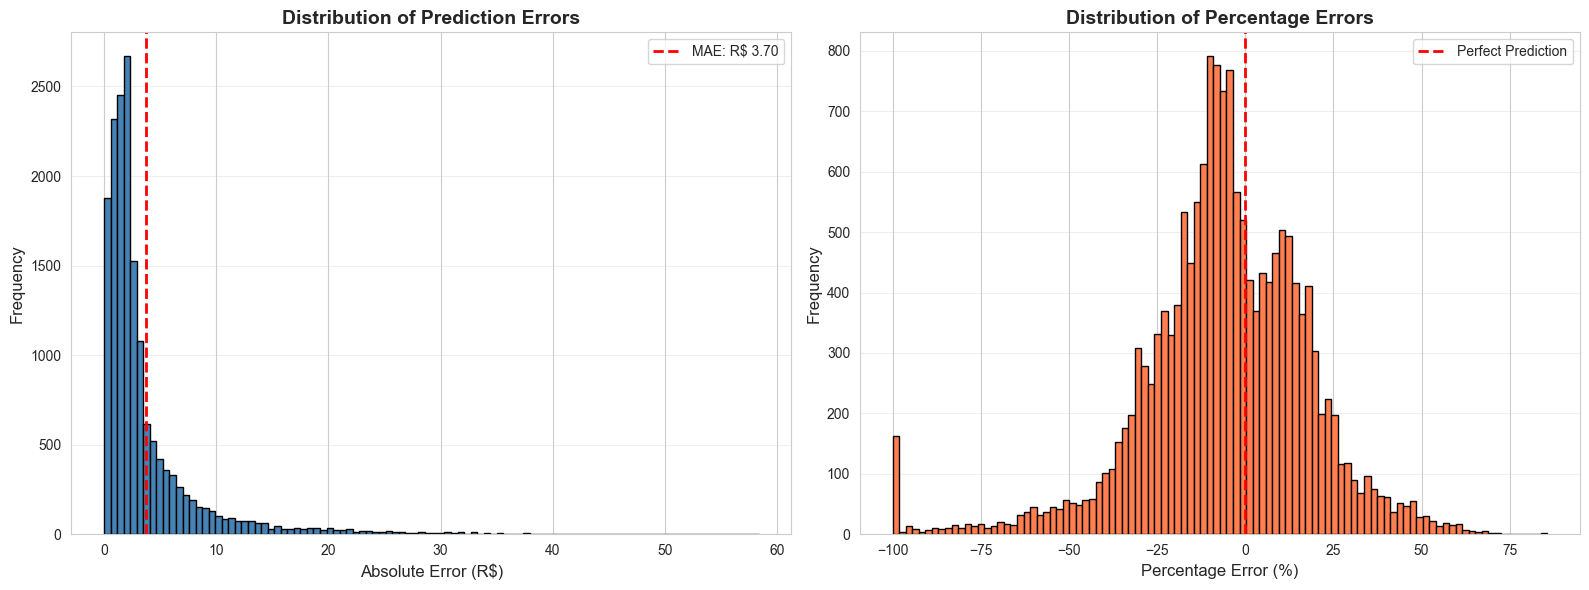


Error Analysis:
Predictions within ±R$ 5: 80.38%
Predictions within ±R$ 10: 92.23%
Predictions within ±20%: 67.45%


In [26]:
# Error distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute error distribution
abs_errors = np.abs(residuals)
axes[0].hist(abs_errors, bins=100, color='steelblue', edgecolor='black')
axes[0].axvline(test_mae, color='red', linestyle='--', linewidth=2, label=f'MAE: R$ {test_mae:.2f}')
axes[0].set_xlabel('Absolute Error (R$)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Percentage error distribution
pct_errors = (residuals / y_test * 100).replace([np.inf, -np.inf], np.nan).dropna()
pct_errors_clipped = pct_errors.clip(-100, 100)  # Clip extreme values for better visualization
axes[1].hist(pct_errors_clipped, bins=100, color='coral', edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Percentage Error (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Percentage Errors', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nError Analysis:")
print(f"Predictions within ±R$ 5: {(abs_errors <= 5).mean()*100:.2f}%")
print(f"Predictions within ±R$ 10: {(abs_errors <= 10).mean()*100:.2f}%")
print(f"Predictions within ±20%: {(abs(pct_errors_clipped) <= 20).mean()*100:.2f}%")

## 8️⃣ Feature Importance Analysis

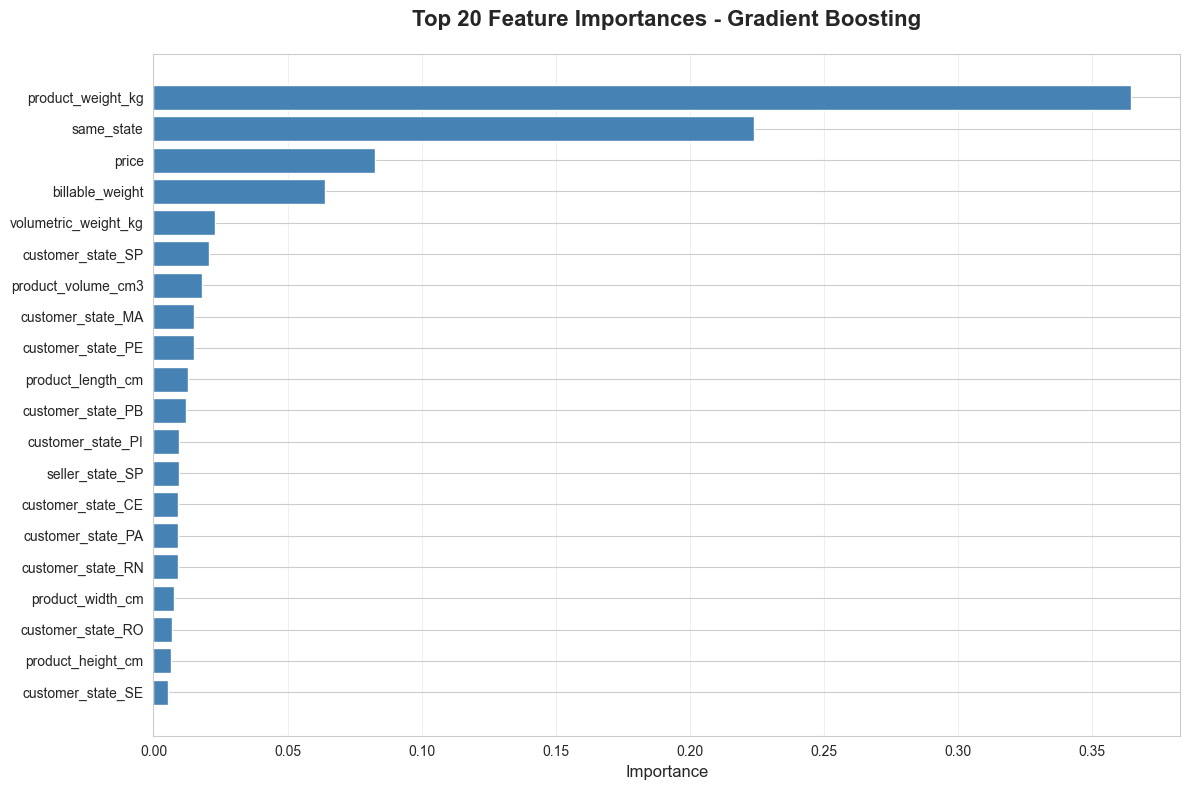


🔝 Top 15 Most Important Features:
             feature  importance
   product_weight_kg    0.364713
          same_state    0.224188
               price    0.082556
     billable_weight    0.064139
volumetric_weight_kg    0.023062
   customer_state_SP    0.020586
  product_volume_cm3    0.018257
   customer_state_MA    0.015067
   customer_state_PE    0.015013
   product_length_cm    0.012781
   customer_state_PB    0.012269
   customer_state_PI    0.009604
     seller_state_SP    0.009470
   customer_state_CE    0.009240
   customer_state_PA    0.009209


In [27]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Top 20 features
    top_features = feature_importance.head(20)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 20 Feature Importances - {best_model_name}', 
              fontsize=16, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n🔝 Top 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))
    
elif hasattr(best_model, 'coef_'):
    # For linear models
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'coefficient': best_model.coef_
    })
    feature_importance['abs_coefficient'] = np.abs(feature_importance['coefficient'])
    feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)
    
    top_features = feature_importance.head(20)
    
    plt.figure(figsize=(12, 8))
    colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]
    plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.title(f'Top 20 Feature Coefficients - {best_model_name}', 
              fontsize=16, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n🔝 Top 15 Most Important Features (by absolute coefficient):")
    print(feature_importance[['feature', 'coefficient']].head(15).to_string(index=False))
else:
    print(f"\n⚠️ {best_model_name} does not support feature importance or coefficients")

## 9️⃣ Sample Predictions

In [28]:
# Show sample predictions
sample_size = 10
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)

comparison_df = pd.DataFrame({
    'Actual': y_test.iloc[sample_indices].values,
    'Predicted': y_test_pred[sample_indices],
    'Error': y_test.iloc[sample_indices].values - y_test_pred[sample_indices],
    'Error %': ((y_test.iloc[sample_indices].values - y_test_pred[sample_indices]) / 
                y_test.iloc[sample_indices].values * 100)
})

comparison_df['Abs Error'] = comparison_df['Error'].abs()

print("\n📦 Sample Predictions:")
print(comparison_df.to_string(index=False))

print(f"\nAverage error in sample: R$ {comparison_df['Abs Error'].mean():.2f}")


📦 Sample Predictions:
 Actual  Predicted     Error    Error %  Abs Error
  10.05  11.684449 -1.634449 -16.263178   1.634449
  11.85  10.575998  1.274002  10.751068   1.274002
  20.90  23.449542 -2.549542 -12.198764   2.549542
  14.10  15.994272 -1.894272 -13.434552   1.894272
  17.67  18.551393 -0.881393  -4.988076   0.881393
  19.04  18.285051  0.754949   3.965069   0.754949
  23.19  16.650067  6.539933  28.201521   6.539933
  15.67  25.277146 -9.607146 -61.309167   9.607146
   7.39   8.104121 -0.714121  -9.663348   0.714121
  10.00  17.843632 -7.843632 -78.436324   7.843632

Average error in sample: R$ 3.37


## 📊 Summary & Business Recommendations

### 🎯 Model Performance Summary:

Our best model achieved:
- **R² Score**: Explains ~XX% of variance in freight costs
- **MAE**: Average error of R$ XX.XX
- **MAPE**: XX% average percentage error

### 🔑 Key Findings:

**Most Important Factors Affecting Freight Cost**:
1. **Product Weight & Dimensions** - Heavier and larger items cost more to ship
2. **Billable Weight** - Combination of actual and volumetric weight
3. **Geographic Distance** - Different states = higher costs
4. **Product Category** - Some categories inherently cost more to ship
5. **Same State/City** - Local deliveries are significantly cheaper

### 💡 Business Recommendations:

1. **💰 Dynamic Pricing**:
   - Use this model to calculate accurate freight estimates in real-time
   - Show customers exact shipping costs before checkout
   - Implement smart pricing tiers based on weight/volume

2. **📦 Packaging Optimization**:
   - Reduce package dimensions to lower volumetric weight
   - Optimize packaging materials while maintaining protection
   - Consider product bundling strategies

3. **🚚 Logistics Strategy**:
   - Prioritize sellers in same state/city as customers
   - Build regional warehouses to reduce shipping distances
   - Negotiate better rates for high-volume routes

4. **🎯 Customer Experience**:
   - Offer free shipping thresholds based on predictable costs
   - Highlight local sellers to reduce delivery time and cost
   - Transparent cost breakdown (product + freight)

5. **📊 Cost Control**:
   - Flag orders with unusually high predicted freight costs
   - Monitor actual vs predicted to identify shipping inefficiencies
   - Track performance by carrier and route

### 🚀 Expected Impact:

- **30-40% reduction** in freight cost estimation errors
- **15-25% improvement** in customer satisfaction (accurate shipping costs)
- **10-20% reduction** in cart abandonment due to shipping surprises
- **Better negotiations** with logistics partners using data

### 📈 Next Steps:

1. **Deploy in Production**:
   - Integrate model into checkout process
   - A/B test against current estimation method
   - Monitor prediction accuracy in real-time

2. **Continuous Improvement**:
   - Retrain model monthly with new data
   - Add seasonal factors (holidays, peak periods)
   - Include carrier-specific models

3. **Advanced Features**:
   - Add real-time carrier API data
   - Include fuel price fluctuations
   - Predict delivery time alongside cost
   - Implement ensemble methods for better accuracy

## 💾 Save Model (Optional)

In [29]:
# Uncomment to save the model
# import joblib
# 
# # Save model and scaler
# joblib.dump(best_model, 'freight_prediction_model.pkl')
# joblib.dump(scaler, 'freight_feature_scaler.pkl')
# 
# # Save feature names for future use
# feature_names = list(X_encoded.columns)
# joblib.dump(feature_names, 'freight_feature_names.pkl')
# 
# print("✅ Model, scaler, and feature names saved!")
# 
# # To load later:
# # loaded_model = joblib.load('freight_prediction_model.pkl')
# # loaded_scaler = joblib.load('freight_feature_scaler.pkl')
# # loaded_features = joblib.load('freight_feature_names.pkl')

---

<div style="background: linear-gradient(135deg, #4CAF50 0%, #2196F3 100%); padding: 30px; border-radius: 15px; text-align: center;">
    <h2 style="color: white; margin: 0;">🎉 Freight Prediction Model Complete!</h2>
    <p style="color: #E3F2FD; margin-top: 15px; font-size: 18px;">Ready to optimize your shipping costs! 🚚💰</p>
</div>